In [79]:
import sys
import os

import torch
import random
import warnings
import time

import torch.nn as nn
import torch.nn.functional as F
import torch.multiprocessing as mp
import torchvision
import torchvision.transforms.functional as TF
import numpy as np
import pandas as pd
from scipy.ndimage import gaussian_filter1d
import matplotlib.pyplot as plt
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader, Sampler, SequentialSampler, BatchSampler
from cca_zoo.linear import rCCA
from joblib import Parallel, delayed

warnings.filterwarnings("ignore")

# Import MI files
from utils import *
from models import *
from estimators import *

plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = "Times New Roman"
plt.rcParams["mathtext.fontset"] = "cm"
plt.rcParams['figure.dpi'] = 100

# Set global font sizes for better readability
plt.rcParams.update({'font.size': 16})
plt.rcParams.update({'axes.titlesize': 18})
plt.rcParams.update({'axes.labelsize': 16})
plt.rcParams.update({'xtick.labelsize': 15})
plt.rcParams.update({'ytick.labelsize': 15})
plt.rcParams.update({'legend.fontsize': 15})

# To-do list:
- Parallel training with shared memory
- Kernel convolution with spikes to get continuous form, run MI
- Train/test split as function so repeated calls get different splits
- Make infoNCE inference chunked so it can run on large datasets

In [2]:
# Check if CUDA or MPS is running
if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device = 'mps'
else:
    device = "CPU"

print(f'Device: {device}')

Device: cuda


In [3]:
# Define a function that reads the data and make it to X and Y with specific binning (or its lackoff)
def process_spike_data(base_name, bin_size=None, neuron_label_filter=None, sample_rate=30000):
    """
    Processes spike data from a .npz file into neural (X) and muscle (Y) activity tensors.
    
    Parameters:
        base_name (str): Base name of the files (e.g., '2025-03-21').
                         The function will look for '_data.npz' and '_labels.npz'.
        bin_size (float, optional): Bin size in seconds. If None, returns raw spikes.
        neuron_label_filter (str, optional): Filter neurons by label (e.g., "good").
                                             Only used if a labels file is present.
        sample_rate (float, 30000 Hz by default): The sampling rate for the data
        
    Returns:
        X (numpy.ndarray): Neural activity tensor of shape (num_neurons, num_time_points).
        Y (numpy.ndarray): Muscle activity tensor of shape (num_muscles, num_time_points).
        neuron_labels (list): List of neuron labels corresponding to rows in X.
        muscle_labels (list): List of muscle labels corresponding to rows in Y.
    """
    # Construct file paths
    data_file = f"{base_name}_data.npz"
    labels_file = f"{base_name}_labels.npz"

    # Load the spike data
    if not os.path.exists(data_file):
        raise FileNotFoundError(f"Data file '{data_file}' not found.")
    
    data = np.load(data_file)
    units = data.files  # List of unit labels

    # Load the labels file if it exists
    labels = {}
    if os.path.exists(labels_file):
        labels_data = np.load(labels_file)
        labels = {unit: labels_data[unit].item() for unit in labels_data.files}

    # Separate neurons and muscles, applying filtering if needed
    neuron_labels = []
    muscle_labels = []

    for unit in units:
        if unit.isnumeric():  # Numeric labels are neurons
            if labels:
                label = labels.get(unit, None)
                if neuron_label_filter is None or label == neuron_label_filter:
                    neuron_labels.append(unit)
            else:
                neuron_labels.append(unit)  # No filtering if no labels file
        else:  # Alphabetic labels are muscles
            muscle_labels.append(unit)

    # Find the maximum spike index to determine total time points
    max_spike_index = max([data[unit].max() for unit in units])

    if bin_size is None:
        # Raw spike representation
        num_time_points = max_spike_index + 1  # Include the last time step

        # Initialize tensors for neural and muscle activity
        X = np.zeros((len(neuron_labels), num_time_points))  # Neural activity
        Y = np.zeros((len(muscle_labels), num_time_points))  # Muscle activity

        # Create binary spike trains for neurons
        for i, unit in enumerate(neuron_labels):
            spike_indices = data[unit]
            X[i, spike_indices] = 1  # Mark spikes as 1 at their respective indices

        # Create binary spike trains for muscles
        for i, unit in enumerate(muscle_labels):
            spike_indices = data[unit]
            Y[i, spike_indices] = 1  # Mark spikes as 1 at their respective indices

    else:
        # Binned spike representation
        bin_samples = int(bin_size * sample_rate)  # Convert bin size to samples
        num_bins = int(np.ceil(max_spike_index / bin_samples))  # Total number of bins

        # Initialize tensors for neural and muscle activity
        X = np.zeros((len(neuron_labels), num_bins))  # Neural activity
        Y = np.zeros((len(muscle_labels), num_bins))  # Muscle activity

        # Bin neural activity
        for i, unit in enumerate(neuron_labels):
            spike_indices = data[unit]
            X[i] = np.histogram(spike_indices, bins=num_bins, range=(0, max_spike_index))[0]

        # Bin muscle activity
        for i, unit in enumerate(muscle_labels):
            spike_indices = data[unit]
            Y[i] = np.histogram(spike_indices, bins=num_bins, range=(0, max_spike_index))[0]

    # Return results
    return X, Y, neuron_labels, muscle_labels

In [4]:
# A helper plotting function
def plot_activity(X, Y, title="Neural and Muscle Activity", cmap='viridis'):
    """
    Plots raster-like visualizations of neural (X) and muscle (Y) activity.
    
    Parameters:
        X (numpy.ndarray): Neural activity tensor of shape (num_neurons, num_time_points).
        Y (numpy.ndarray): Muscle activity tensor of shape (num_muscles, num_time_points).
        title (str, optional): Title of the plot.
        cmap (str, optional): Colormap for the heatmap (default: 'viridis').
    """
    # Detect non-zero activity regions
    def find_active_region(activity):
        """Finds the first region with non-zero activity."""
        non_zero_cols = np.any(activity > 0, axis=0)
        active_start = np.argmax(non_zero_cols)
        active_end = len(non_zero_cols) - np.argmax(non_zero_cols[::-1])
        return active_start, active_end

    # Find active regions for X and Y
    x_active_start, x_active_end = find_active_region(X)
    y_active_start, y_active_end = find_active_region(Y)

    # Determine the shared time range for plotting
    start = min(x_active_start, y_active_start)
    end = max(x_active_end, y_active_end)

    # Clip the data to the active region
    X_plot = X[:, start:end]
    Y_plot = Y[:, start:end]

    # Create the figure and subplots
    fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True, gridspec_kw={'hspace': 0.3})

    # Plot neural activity (X)
    im_x = axes[0].imshow(
        X_plot, aspect='auto', cmap=cmap, interpolation='none',
        extent=[start, end, 0, X.shape[0]], origin='lower'
    )
    axes[0].set_title("Neural Activity")
    axes[0].set_ylabel("Neurons")
    fig.colorbar(im_x, ax=axes[0], orientation='vertical', label="Activity")

    # Plot muscle activity (Y)
    im_y = axes[1].imshow(
        Y_plot, aspect='auto', cmap=cmap, interpolation='none',
        extent=[start, end, 0, Y.shape[0]], origin='lower'
    )
    axes[1].set_title("Muscle Activity")
    axes[1].set_xlabel("Time Points")
    axes[1].set_ylabel("Muscles")
    fig.colorbar(im_y, ax=axes[1], orientation='vertical', label="Activity")

    # Add overall title
    fig.suptitle(title, fontsize=16)

    # Show the plot
    plt.show()

def plot_activity_side_by_side(X, Y, title="Neural and Muscle Activity", highlight_activity=True):
    """
    Plots neural (X) and muscle (Y) activity side by side using line plots.
    
    Parameters:
        X (numpy.ndarray): Neural activity tensor of shape (num_neurons, num_time_points).
        Y (numpy.ndarray): Muscle activity tensor of shape (num_muscles, num_time_points).
        title (str, optional): Title of the plot.
        highlight_activity (bool, optional): If True, zooms in on regions with non-zero activity.
    """
    # Detect non-zero activity regions
    def find_active_region(activity):
        """Finds the first region with non-zero activity."""
        non_zero_cols = np.any(activity > 0, axis=0)
        active_start = np.argmax(non_zero_cols)
        active_end = len(non_zero_cols) - np.argmax(non_zero_cols[::-1])
        return active_start, active_end

    # Find active regions for X and Y
    x_active_start, x_active_end = find_active_region(X)
    y_active_start, y_active_end = find_active_region(Y)

    # Determine the shared time range for plotting
    if highlight_activity:
        start = min(x_active_start, y_active_start)
        end = max(x_active_end, y_active_end)
    else:
        start, end = 0, X.shape[1]  # Use the full range if no highlighting

    # Clip the data to the active region
    X_plot = X[:, start:end].T
    Y_plot = Y[:, start:end].T

    # Create the figure and subplots
    fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharex=True, gridspec_kw={'wspace': 0.3})

    # Plot neural activity (X)
    axes[0].plot(X_plot, alpha=0.7)
    axes[0].set_title("Neural Activity")
    axes[0].set_ylabel("Activity")
    axes[0].set_xlabel("Time Points")
    axes[0].grid(True, linestyle='--', alpha=0.5)

    # Plot muscle activity (Y)
    axes[1].plot(Y_plot, alpha=0.7)
    axes[1].set_title("Muscle Activity")
    axes[1].set_ylabel("Activity")
    axes[1].set_xlabel("Time Points")
    axes[1].grid(True, linestyle='--', alpha=0.5)

    # Add overall title
    fig.suptitle(title, fontsize=16)

    # Show the plot
    plt.show()

In [ ]:
# Train function with early stopping
def train_model(model, full_dataset, opt_params, model_type="dsib", patience=50, min_delta=0.001):
    """
    Generalized training function for DSIB and DVSIB models with early stopping.
    Args:
        model: The model to train (DSIB or DVSIB).
        data: Tuple of (train, test, eval) dataloaders. 
            Assumes uses BatchSubsetDataset with custom sampler
            Assumes loaders return X, Y of shapes (M_x, N) and (M_y, N)
        model_type: Either "dsib" (returns loss, that's negative mi) or "dvsib" (returns loss, lossGin, lossGout).
        patience: Number of epochs to wait for improvement before stopping.
        min_delta: Minimum change to qualify as an improvement.
    Returns:
        A tuple (train_estimates, test_estimates) containing mutual information estimates.
    """
    model.to(device)  # Ensure model is on GPU
    epochs = opt_params['epochs']
    opt = torch.optim.Adam(model.parameters(), lr=opt_params['learning_rate'])
    estimates_mi_train = []
    estimates_mi_test = []
    # Pull out data loaders
    train_data, test_data, eval_data = full_dataset
    # Early stopping variables
    best_estimator_ts = float('-inf')  # Initialize with negative infinity
    no_improvement_count = 0

    for epoch in range(epochs):        
        for i, (x, y) in enumerate(iter(train_data)):
            x, y = x.T.to(device), y.T.to(device)
            opt.zero_grad()
            # Compute loss based on model type
            if model_type == "dsib":
                loss = model(x, y)  # DSIB returns a single loss
            elif model_type == "dvsib":
                loss, _, _ = model(x, y)  # DVSIB returns three outputs
            else:
                raise ValueError("Invalid model_type. Choose 'dsib' or 'dvsib'.")
            loss.backward()
            opt.step()
        # Evaluate the model at every epoch
        with torch.no_grad():
            if model_type == "dsib":
                estimator_tr = -model(eval_X, eval_Y)
                estimator_ts = -model(test_X, test_Y)
            elif model_type == "dvsib": # Get lossGout, that is the mi value
                _, _, estimator_tr = model(eval_X, eval_Y)
                _, _, estimator_ts = model(test_X, test_Y)
            estimator_tr = estimator_tr.to('cpu').detach().numpy()
            estimator_ts = estimator_ts.to('cpu').detach().numpy()
            estimates_mi_train.append(estimator_tr)
            estimates_mi_test.append(estimator_ts)
        print(f"Epoch: {epoch+1}, {model_type}, train: {estimator_tr}, test: {estimator_ts}", flush=True)
        
        # Check for improvement or negative values
        if estimator_ts < 0:
            no_improvement_count += 1
        elif estimator_ts > best_estimator_ts + min_delta:
            # We have an improvement
            best_estimator_ts = estimator_ts
            no_improvement_count = 0
        else:
            # No significant improvement
            no_improvement_count += 1
        # Check if we should stop early
        if no_improvement_count >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs. Best estimator_ts: {best_estimator_ts}")
            break
    
    return np.array(estimates_mi_train), np.array(estimates_mi_test)

In [6]:
# Read the data and have some binning
# data_dir = "/Users/leo/Desktop/ResearchPhD/VNCMP/localdata/data_for_python"
data_dir = os.path.join(os.getcwd(), '..', 'data_for_python')
X, Y, x_labels, y_labels = process_spike_data(os.path.join(data_dir, '2025-03-12_1'), 0.001)
print(f"Neural Activity (X): {X.shape}")
print(f"Muscle Activity (Y): {Y.shape}") 
print("Neuron Labels:", x_labels)
print("Muscle Labels:", y_labels)

Neural Activity (X): (46, 1526608)
Muscle Activity (Y): (10, 1526608)
Neuron Labels: ['32', '29', '81', '53', '51', '27', '75', '33', '28', '52', '50', '26', '10', '23', '49', '5', '31', '43', '39', '34', '55', '17', '37', '47', '82', '12', '104', '7', '57', '8', '19', '97', '11', '35', '13', '15', '100', '16', '21', '38', '56', '36', '66', '103', '18', '30']
Muscle Labels: ['ldvm', 'lax', 'rdlm', 'rax', 'rba', 'rdvm', 'lsa', 'ldlm', 'rsa', 'lba']


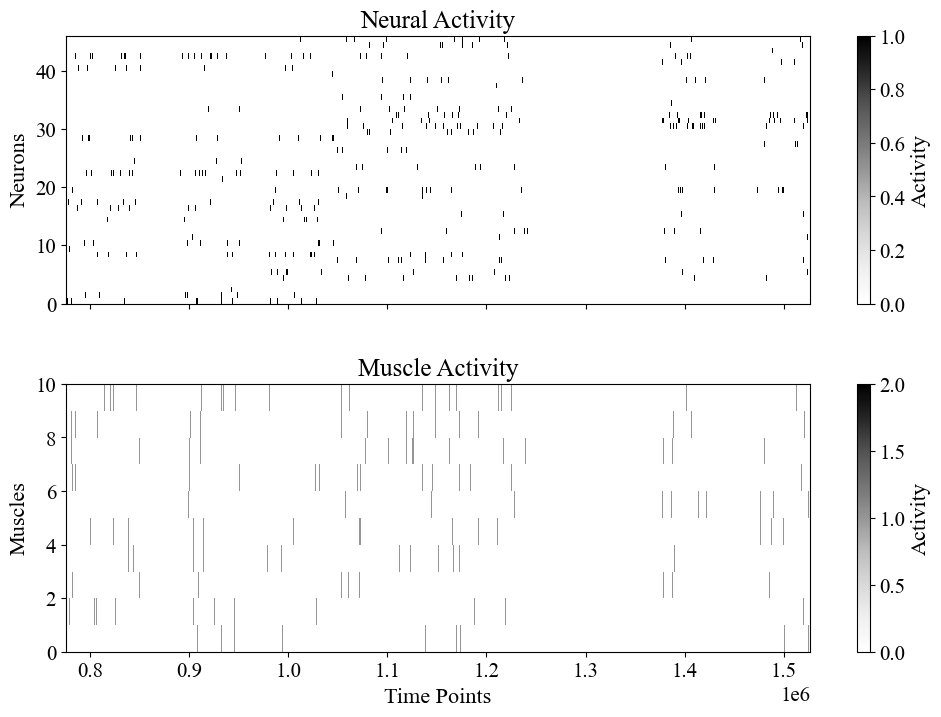

In [9]:
plot_activity(X,Y, title=None, cmap='Greys')

In [7]:
# Optimizer parameters (for training)
opt_params = {
    'epochs': 100,
    'batch_size': 128,
    'learning_rate': 5e-4,
    'n_trials': 2,
}

# Critic parameters for DSIB or DVSIB (for the estimator), except embed_dim, which changes with training
critic_params = {
    'Nx': X.shape[0],
    'Ny': Y.shape[0],
    'layers': 2,
    'hidden_dim': 256,
    'activation': 'leaky_relu',
    'beta': 512,
    'max_dz': 10, # max value for embed_dim that we search for
}

# Model Types (almost always we'll use separable)
model_types = ['sep']

# Estimators: InfoNCE or SMILE_5
estimators = ['infonce'] #['smile_5']

In [ ]:
class BatchSubsetDataset(Dataset):
    """Dataset that holds the entire data but only returns specified batch indices."""
    def __init__(self, X, Y, batch_indices):
        """
        Args:
            X (torch.Tensor): First time series data of shape [M_x, N]
            Y (torch.Tensor): Second time series data of shape [M_y, N]
            batch_indices (list): List of tensors, each tensor containing indices for a batch
        """
        self.X = X
        self.Y = Y
        self.batch_indices = batch_indices
    def __len__(self):
        return len(self.batch_indices)
    def __getitem__(self, idx):
        """Return a batch at the specified index."""
        indices = self.batch_indices[idx]
        return self.X[:, indices], self.Y[:, indices]

def create_batched_dataset(X, Y, opt_params):
    """
    Creates dataset object from X, Y data
    Args:
        X (torch.Tensor): First time series data of shape [M_x, N]
        Y (torch.Tensor): Second time series data of shape [M_y, N]
        opt_params (dict): Dictionary containing optimization parameters
    Returns:
        BatchSubsetDataset
    """
    # Create batches
    all_inds = torch.arange(X.shape[1])
    total_batches = (X.shape[1] + opt_params['batch_size'] - 1) // opt_params['batch_size']
    batch_indices = []
    for i in range(total_batches):
        start_idx = i * opt_params['batch_size']
        end_idx = min(start_idx + opt_params['batch_size'], X.shape[1])
        batch_inds = all_inds[start_idx:end_idx]
        if torch.any(X[:, batch_inds] > 0) and torch.any(Y[:, batch_inds] > 0):
            batch_indices.append(batch_inds)
    # Create the shared dataset that holds all data
    full_dataset = BatchSubsetDataset(X, Y, batch_indices)
    return full_dataset

def create_data_loaders(full_dataset, train_fraction=0.95, eval_fraction=None, device=None):
    """
    Creates train, test, and eval data loaders that all reference the same data.
    Args:
        X (torch.Tensor): First time series data of shape [M_x, N]
        Y (torch.Tensor): Second time series data of shape [M_y, N]
        opt_params (dict): Dictionary containing optimization parameters
        train_fraction (float): Fraction of data to use for training
        device (torch.device): Device to move data to (for test and eval)
    Returns:
        tuple: (train_loader, test_loader, eval_loader)
    """
    # Generate batch assignments for train/test split
    batch_assignments = torch.randperm(len(full_dataset.batch_indices))
    split_idx = int(np.rint(train_fraction * len(full_dataset.batch_indices)))
    # Create train sampler and loader
    train_loader = DataLoader(
        full_dataset, 
        sampler=batch_assignments[:split_idx],
        num_workers=0)  # Adjust based on your system
    # Create test dataset
    test_loader = DataLoader(
        full_dataset, 
        sampler=batch_assignments[split_idx:],
        num_workers=0)
    # Create eval sampler using a different random permutation
    if eval_fraction is None:
        eval_fraction = 1 - train_fraction
    split_idx = int(np.rint(eval_fraction * len(full_dataset.batch_indices)))
    eval_assignments = torch.randperm(len(full_dataset.batch_indices))[split_idx:]
    eval_loader = DataLoader(
        full_dataset, 
        sampler=eval_assignments,
        num_workers=0)
    return train_loader, test_loader, eval_loader

In [112]:
full_dataset = create_batched_dataset(X, Y, opt_params)
full_data_loader = create_data_loaders(full_dataset)
train_data, test_data, eval_data = full_data_loader
# for x,y in iter(test_data):
#     print(x)
#     print(y)
#     break
[x for x,_ in iter(test_data)][0].shape

torch.Size([1, 46, 128])

In [ ]:
train_fraction = 0.95
full_dataset = create_batched_dataset(X, Y, opt_params)
batch_assignments = torch.randperm(len(full_dataset.batch_indices))
split_idx = int(np.rint(train_fraction * len(full_dataset.batch_indices)))
# print(batch_assignments[:split_idx])
# list(SequentialSampler(batch_assignments[:split_idx]))
eval_loader = DataLoader(
    full_dataset, 
    sampler=batch_assignments[:split_idx],
    num_workers=0)
for x, y in iter(eval_loader):
    print(x)
    print(y)
    break

tensor([[[1., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])
tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])


In [ ]:
# Make into tensors
X, Y = torch.tensor(X, dtype=torch.float32), torch.tensor(Y, dtype=torch.float32)


In [ ]:
# Split the data and make it to the loader:
# Make into tensors
X, Y = torch.tensor(X, dtype=torch.float32), torch.tensor(Y, dtype=torch.float32)
train_fraction = 0.95
# Create batches
all_inds = torch.arange(X.shape[1])
total_batches = (X.shape[1] + opt_params['batch_size'] - 1) // opt_params['batch_size']
batch_indices = []
for i in range(total_batches):
    start_idx = i * opt_params['batch_size']
    end_idx = min(start_idx + opt_params['batch_size'], X.shape[1])
    batch_inds = all_inds[start_idx:end_idx]
    if torch.any(X[:,batch_inds] > 0) and torch.any(Y[:,batch_inds] > 0):
        batch_indices.append(batch_inds)
batch_assignments = torch.randperm(len(batch_indices))
split_idx = np.rint(train_fraction * len(batch_indices)).astype(int)
train_indices = torch.cat(batch_indices[batch_assignments][:split_idx])
test_indices = torch.cat(batch_indices[batch_assignments][split_idx:])
# Create train and test datasets
train_X, train_Y = X[:, train_indices].T, Y[:, train_indices].T
test_X, test_Y = X[:, test_indices].T.to(device), Y[:, test_indices].T.to(device) # move to device
# Create eval dataset
batch_assignments = torch.randperm(len(batch_indices))
eval_indices = torch.cat(batch_indices[batch_assignments][:split_idx])
eval_X, eval_Y = X[:,eval_indices].T.to(device), Y[:,eval_indices].T.to(device)
data_eval_test = (eval_X, eval_Y, test_X, test_Y)

# Make it into a dataset object which is used to make the loader we'll use in training
trainData = Dataset(train_X, train_Y)
data_train = torch.utils.data.DataLoader(trainData, batch_size=opt_params['batch_size'], shuffle=False)

torch.Size([46, 1526608])

In [11]:
# Empty arrays and do the run, will take forever
mi = {}
mi_test = {}

for dz in range(1, critic_params['max_dz']+1):
    critic_params = {**critic_params, 'embed_dim': dz} # Choose dz
    print(f'Starting dz = {dz}')
    for j in range(opt_params['n_trials']):
        print(f'dz = {dz}, trial = {j+1}')
        torch.cuda.empty_cache()
        dsib_model = DSIB(estimators[0], critic_params, model_types[0], None)
        mis, mis_test = train_model(dsib_model, data_train, data_eval_test, opt_params, "dsib")
        
        # Store results
        mi[f"trial_{j}_dz_{dz}"] = mis
        mi_test[f"trial_{j}_dz_{dz}"] = mis_test


Starting dz = 1
dz = 1, trial = 1
Epoch: 1, dsib, train: -0.00031293119536712766, test: 0.003909082617610693
Epoch: 2, dsib, train: -8.317430183524266e-05, test: 0.003957795444875956
Epoch: 3, dsib, train: -4.2019517422886565e-05, test: 0.003919156733900309
Epoch: 4, dsib, train: 0.00017855899932328612, test: 0.003825280349701643
Epoch: 5, dsib, train: 0.0001930203870870173, test: 0.003845883533358574
Epoch: 6, dsib, train: 0.0003878372081089765, test: 0.0038078061770647764
Epoch: 7, dsib, train: 0.00036547810304909945, test: 0.0036141700111329556
Epoch: 8, dsib, train: 0.0005065579898655415, test: 0.0035703035537153482
Epoch: 9, dsib, train: 0.000498499721288681, test: 0.0034570610150694847
Epoch: 10, dsib, train: 0.0006005953764542937, test: 0.003254072740674019
Epoch: 11, dsib, train: 0.0006928339716978371, test: 0.0030934764072299004
Epoch: 12, dsib, train: 0.0008123010629788041, test: 0.002877576509490609
Epoch: 13, dsib, train: 0.0008865832933224738, test: 0.0026663485914468765
E

In [ ]:
# Parallelized logic
# Define the function to handle one trial
def run_trial(dz, j, critic_params, estimators, model_types, opt_params, 
        data_train, data_eval_test, 
        device):
    """
    Run a single trial for given dz and j.
    
    Parameters:
        dz (int): Embedding dimension.
        j (int): Trial index.
        critic_params (dict): Critic parameters.
        estimators (list): List of estimators.
        model_types (list): List of model types.
        opt_params (dict): Optimization parameters.
        data_train: Training data.
        data_eval_test: Tuple of evaluation and test datasets
        device: Device to use (e.g., 'cuda', 'mps', 'cpu').
    
    Returns:
        tuple: Results for this trial (key, mis, mis_test).
    """
    # Set device explicitly for this process
    torch.cuda.empty_cache()  # Clear cache before starting
    if device.startswith('cuda'):
        torch.device('cuda')
    elif device == 'mps':
        torch.device('mps')
    else:
        torch.device('cpu')

    # Update critic_params with the current dz
    critic_params = {**critic_params, 'embed_dim': dz}

    # Initialize and train the model
    dsib_model = DSIB(estimators[0], critic_params, model_types[0], None).to(device)
    mis, mis_test = train_model(dsib_model, data_train, data_eval_test, opt_params, "dsib")

    # Return results as a tuple
    return f"trial_{j}_dz_{dz}", mis, mis_test

# Main function to parallelize the loops
def parallel_run(critic_params, estimators, model_types, opt_params, data_train, data_eval_test, device='cpu'):
    """
    Parallelize the training process across dz and trials.
    
    Parameters:
        critic_params (dict): Critic parameters.
        estimators (list): List of estimators.
        model_types (list): List of model types.
        opt_params (dict): Optimization parameters.
        data_train: Training data.
        device (str): Device to use (e.g., 'cuda', 'mps', 'cpu').
    
    Returns:
        dict, dict: mi and mi_test dictionaries containing results.
    """
    # Prepare arguments for parallel execution
    tasks = [
        (dz, j, critic_params, estimators, model_types, opt_params, data_train, data_eval_test, device)
        for dz in range(1, critic_params['max_dz'] + 1)
        for j in range(opt_params['n_trials'])
    ]

    # Run tasks in parallel
    results = Parallel(n_jobs=2)(  # Use all available cores
        delayed(run_trial)(*task) for task in tasks
    )

    # Aggregate results into mi and mi_test dictionaries
    mi = {}
    mi_test = {}
    for key, mis, mis_test in results:
        mi[key] = mis
        mi_test[key] = mis_test

    return mi, mi_test

In [ ]:
def run_trial(
        j, dz,
        data_params, opt_params, critic_params, 
        estimators, model_types, 
        data_train, data_eval_test, 
        device):
    """
    Run a single trial for given dz and j.
    
    Parameters:
        j (int): Trial index.
        dz (int): Embedding dimension.
        data_params (dict): Batch indices, permutations of train/test split for each trial
        opt_params (dict): Optimization and run parameters.
        critic_params (dict): Critic parameters.
        estimators (list): List of estimators.
        model_types (list): List of model types.
        data_train: Training data.
        data_eval_test: Tuple of evaluation and test datasets
        device: Device to use (e.g., 'cuda', 'mps', 'cpu').
    
    Returns:
        tuple: Results for this trial (key, mis, mis_test).
    """
    # Set device explicitly for this process
    torch.cuda.empty_cache()  # Clear cache before starting
    torch.device(device)
    # Update critic_params with the current dz
    critic_params = {**critic_params, 'embed_dim': dz}
    # Create dataloader for train, eval, test
    train_inds = torch.cat(data_params['batch_indices'][data_params['trial_permutations'][j]][:data_params['split_idx']])
    test_inds = torch.cat(data_params['batch_indices'][data_params['trial_permutations'][j]][data_params['split_idx']:])
    # train_X, train_Y = X[:, train_indices].T, Y[:, train_indices].T
    # test_X, test_Y = X[:, test_indices].T.to(device), Y[:, test_indices].T.to(device)
    data_train = DataLoader()
    # Initialize and train the model
    dsib_model = DSIB(estimators[0], critic_params, model_types[0], None).to(device)
    mis, mis_test = train_model(dsib_model, data_train, data_eval_test, opt_params, "dsib")

    # Return results as a tuple
    return f"trial_{j}_dz_{dz}", mis, mis_test

In [ ]:
# Set up multiprocessing
mp.set_start_method('spawn')
queue = mp.Queue()

# Define iterator of conditions to loop over
iter = []

for i in iter:
    # Run on same GPU but with controlled allocation
    p = mp.Process(target=train_func, args=())
    p.start()

In [10]:
# Run the parallelized process
mi, mi_test = parallel_run(
    critic_params=critic_params,
    estimators=estimators,
    model_types=model_types,
    opt_params=opt_params,
    data_train=data_train,
    data_eval_test=data_eval_test,
    device=device
)

KeyboardInterrupt: 

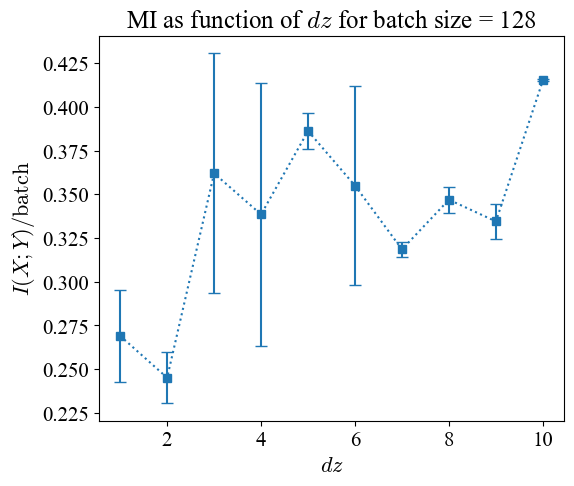

In [ ]:
EMA_SPAN = 5 # smoothing, set to 1 if you don't want smoothing
dz_means = []
dz_stds = []

fig, ax = plt.subplots(figsize=(6,5))
for dz in range(1, critic_params['max_dz']+1):
    mi_trials = []
    for j in range(opt_params['n_trials']):
        key = f"trial_{j}_dz_{dz}"

        # Define sigma, a small number is usually the best choice
        sigma=1 # (or 2 at most)
        # Convert Nan to zeros and smooth
        train = gaussian_filter1d(np.nan_to_num(mi[key]), sigma=sigma)
        test = gaussian_filter1d(np.nan_to_num(mi_test[key]), sigma=sigma)

        # Pick the epoch with highest test value and get corresponding train
        best = np.argmax(test)
        
        mi_trials.append(train[best])

    dz_means.append(np.mean(np.array(mi_trials)).flatten())
    dz_stds.append(np.std(np.array(mi_trials)).flatten())


b = ax.errorbar(
    range(1, critic_params['max_dz']+1), np.array(dz_means).flatten(), 
    yerr=np.array(dz_stds).flatten(), 
    fmt='s:', capsize=4)

# Set title and scales
ax.set_title(r"MI as function of $dz$ for batch size = "+str(opt_params['batch_size']))
ax.set_xlabel(r'$dz$')
ax.set_ylabel(r'$I(X;Y)/\text{batch}$');


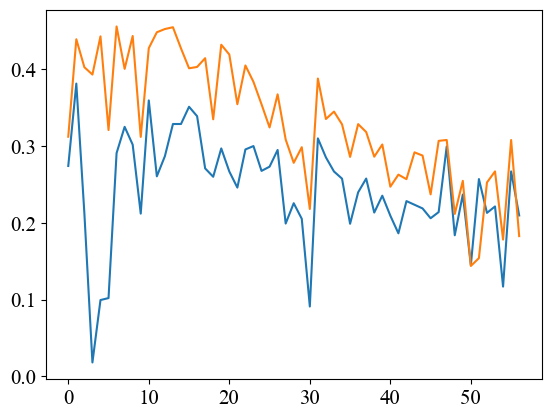

In [364]:
plt.plot(mi['trial_0_dz_1'])
plt.plot(mi_test['trial_0_dz_1'])